# Constructing ISI's COVID-19 Knowledge Graph

This notebook shows how we use our KGTK toolking (link) to construct the COVID-19 knowledge graph for the CORD-19 corpus using the text extractions from the BLENDER group at UIUC. The text extractions inlcude a variety of entity extractions with links to bioinformatics databases. Our approach is to:

* extract from Wikidata the subgraph that covers all the publications in the CORD-19 corpus and the entities identified by the BLENDER group.
* define new Wikidata items for publications or entities that are not present in the public Wikidata
* annotate the article items with the relevant entities
* preserve provenance

We implement the approach in the following steps:

* data prepararation: convert the JSON representation of BLENDER output to CSV files that are easy to process
* extract Wikidata subgraph: extract from Wikidata the articles, authors, and entities mentioned in the BLENDER corpus
* create missing items: create nodes for articles and entities that are not present in Wikidata
* create mention edges: create edges to record the entity extractions from BLENDER, including justifications
* incorporate analytic outputs: add edges to record graph metrics such as pagerank
* export knowledge graph: export the graph to KGTL edges, RDF and Neo4J 

## Data Preparation

Set up environment variables with location of the input files

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
%env COVID=/Users/amandeep/Github/CKG-Covid/datasets/sandbox
%env WD=/Users/amandeep/Documents/wikidata-20200504

env: COVID=/Users/amandeep/Github/CKG-Covid/datasets/sandbox
env: WD=/Users/amandeep/Documents/wikidata-20200504


### Wikidata Data

The Wikidata files are the large:

* `wikidata_nodes_20200504.tsv.gz` the English labels, alias and descriptions for all items in Wikidata
* `wikidata_edges_20200504.tsv.gz` the edges for all statements in Wikidata
* `wikidata_qualifiers_20200504.tsv.gz` the qualifier edges for all statements in Wikidata

In [ ]:
ls -lh "$WD"

Working with the dump files takes time because they are so large (86B chars and 1.1B lines), more than 6 minutes to just unzip and count lines

In [ ]:
!time gzcat "$WD/wikidata_edges_20200504.tsv.gz" | wc

The columns in the edge files:

* `id` is a unique identifier for an edge, and provides an identifier for each statement in Wikidata
* `node1`, `label` and `node2` are the item/property/value or subject/predicate/object
* `rank` is the Wikidata rank for the statement
* `node2;*` are additional columns that provide detailed information about the `node2` column, making it easy to parse

In [ ]:
!gzcat "$WD/wikidata_edges_20200504.tsv.gz" | head

### BLENDER Data

The BLENDER data came in a JSON document per article. We used Python scripts to create simple TSV files that are easy to process.

The `corpus-identifiers.tsv` file contains all the identifiers present in the BLENDER dataset with two columns:

* node2: the value of the identifier
* label: the name of the property in Wikidata used to represent the specific identifier. For example `P698` is PubMed ID. See https://www.wikidata.org/wiki/Q93157077

In [3]:
ids = pd.read_csv(os.getenv("COVID")+'/corpus-identifiers.tsv', delimiter='\t')
ids

,node2,label
0,3670673,P932
1,22621853,P698
2,9606,P685
3,851819,P351
4,851323,P351
...,...,...
99799,19423234,P698
99800,22609285,P698
99801,12781505,P698
99802,10028170,P698


## Extract Wikidata Subgraph

### Step 1: find the `node1` for all the rows in `corpus-identifiers.tsv`

We do this with the `kgtk ifexists` command to scan the file of all edges in Wikidata to select the ones where `label` and `node2` match the rows in `corpus-identifiers.tsv`. We store the results in `corpus-identifier-edges.tsv`

In [4]:
!time gzcat "$WD/wikidata_edges_20200504.tsv.gz" \
  | kgtk ifexists --input-keys label node2 --filter-on $COVID/corpus-identifiers.tsv --filter-keys label node2 --filter-mode NONE \
  > $COVID/corpus-identifier-edges.tsv


real	43m17.833s
user	46m24.846s
sys	0m53.892s


We found 72,649 q-nodes in Wikidata for the identifiers in our corpus. 

In [6]:
idedges = pd.read_csv(os.getenv("COVID")+'/corpus-identifier-edges.tsv', delimiter='\t')
#idedges.loc[:, [ 'node2']]

In [7]:
idedges

,id,node1,label,node2,rank,node2;magnitude,node2;unit,node2;date,node2;item,node2;lower,node2;upper,node2;latitude,node2;longitude,node2;precision,node2;calendar,node2;entity-type
0,Q140-P685-1,Q140,P685,9689,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q556-P486-1,Q556,P486,D006859,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Q688-P486-1,Q688,P486,D002713,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q716-P486-1,Q716,P486,D014025,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Q1832-P486-1,Q1832,P486,D005682,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72645,Q93147847-P932-1,Q93147847,P932,6730851,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72646,Q93157077-P698-1,Q93157077,P698,31492122,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72647,Q93157077-P932-1,Q93157077,P932,6731609,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72648,Q93157501-P698-1,Q93157501,P698,31492169,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here are the counts of the q-nodes we found in Wikidata for each property.

In [8]:
idedges['label'].value_counts()

P698     20426
P351     18235
P932     14169
P486     10096
P685      9721
P5055        3
Name: label, dtype: int64

### Step 2: get all the edges from Wikidata for the q-nodes in `corpus-identifier-edges.tsv`

To do this, we again scan all the edges in Wikidata looking for edges whose `node1` matches the `node1` in `corpus-identifier-edges.tsv`

In [ ]:
!time gzcat "$WD/wikidata_edges_20200504.tsv.gz" \
  | kgtk ifexists --input-keys node1 --filter-on $COVID/corpus-identifier-edges.tsv --filter-keys node1 \
  > $COVID/corpus-edges.tsv

We now have 2.2 million edges for the entities in our corpus.

In [9]:
!wc $COVID/corpus-edges.tsv

 2297783 13662891 176151115 /Users/amandeep/Github/CKG-Covid/datasets/sandbox/corpus-edges.tsv


We can use Pandas to explore the data

In [12]:
ce = pd.read_csv(os.getenv("COVID")+'/corpus-edges.tsv', delimiter='\t', index_col=['id'], dtype=object)

In [13]:
ce.loc[:, ['node1', 'label', 'node2', 'node2;entity-type']].head(5)

,node1,label,node2,node2;entity-type
id,,,,
Q140-P225-1,Q140,P225,Panthera leo,NaN
Q140-P105-1,Q140,P105,Q7432,item
Q140-P171-1,Q140,P171,Q127960,item
Q140-P31-1,Q140,P31,Q16521,item
Q140-P1403-1,Q140,P1403,Q15294488,item


In [14]:
ce[ce['node2;entity-type']=='item'].loc[:, ['node1', 'label', 'node2', 'node2;entity-type']]

,node1,label,node2,node2;entity-type
id,,,,
Q140-P105-1,Q140,P105,Q7432,item
Q140-P171-1,Q140,P171,Q127960,item
Q140-P31-1,Q140,P31,Q16521,item
Q140-P1403-1,Q140,P1403,Q15294488,item
Q140-P141-1,Q140,P141,Q278113,item
...,...,...,...,...
Q93157077-P50-1,Q93157077,P50,Q93157070,item
Q93157077-P921-1,Q93157077,P921,Q12184,item
Q93157501-P1433-1,Q93157501,P1433,Q15752156,item


In [15]:
ce[ce['node2;entity-type']=='item'].label.value_counts()

P2860    540720
P31       62617
P684      52486
P279      28076
P50       25283
          ...  
P4954         1
P5166         1
P4988         1
P2822         1
P1419         1
Name: label, Length: 221, dtype: int64

In [16]:
ce.label.value_counts()[0:20]

P2860                 540720
wikipedia_sitelink    300857
P704                  120845
P2093                 109421
P639                   87783
P31                    62617
P684                   52486
P1843                  38031
P279                   28076
P2888                  26496
P645                   25676
P644                   25670
P50                    25283
P577                   20699
P1476                  20479
P698                   20438
P1433                  20413
P356                   20197
P478                   20164
P688                   19353
Name: label, dtype: int64

We can use the Wikidata cli to see what the top properties:

In [17]:
!wd u P2860, P704, P2093

id P2860
Label cites work
Description citation from one creative work to another
instance of (P31): Wikidata property for items about works (Q18618644)

id P704
Label Ensembl transcript ID
Description transcript ID issued by Ensembl database
instance of (P31): Wikidata property for an identifier (Q19847637) | Wikidata property related to medicine (Q19887775)

id P2093
Label author name string
Description string to store unspecified author name for publications; use if Wikidata item for author (P50) does not exist or is not known
instance of (P31): Wikidata property for items about works (Q18618644) | Wikidata property with datatype string that is not an external identifier (Q21099935) | Wikidata property to indicate a source (Q18608359)


How many authors have items in Wikidata?

In [18]:
ce.node2.value_counts()[0:20]

Q13442814    20473
Q7187        18221
Q20747295    15858
Q15978631    10696
Q16521        9503
Q7432         9053
Q22809680     8136
Q22809711     8090
Q1860         7786
Q83310        4767
1             3385
Q11173        3128
Q12136        3011
2             2207
3             2058
4             2008
6             1898
Q211005       1883
5             1638
7             1603
Name: node2, dtype: int64

In [19]:
!wd u Q13442814, Q7187, Q20747295, Q15978631

id Q13442814
Label scholarly article
Description article in an academic publication, usually peer reviewed
subclass of (P279): scholarly publication (Q591041) | article (Q191067) | scholarly work (Q55915575)

id Q7187
Label gene
Description basic physical and functional unit of heredity
subclass of (P279): Nucleic acid sequence (Q863908) | biological region (Q50365914) | biological sequence (Q3511065)

id Q20747295
Label protein-coding gene
Description Type of a gene
subclass of (P279): gene (Q7187)

id Q15978631
Label Homo sapiens
Description species of mammal
instance of (P31): taxon (Q16521)


In [20]:
!kgtk filter -p ';P50;' $COVID/corpus-edges.tsv | wc -l

   25284


### Step 3:

In [ ]:
!kgtk filter -p ';P50, P2860;' $COVID/corpus-edges.tsv > $COVID/citation-and-author-edges.tsv

In [21]:
caae = pd.read_csv(os.getenv("COVID")+'/citation-and-author-edges.tsv', delimiter='\t')
caae.loc[:, ['id', 'node1', 'label', 'node2']]

,id,node1,label,node2
0,Q21090495-P2860-1,Q21090495,P2860,Q24611162
1,Q21090495-P2860-2,Q21090495,P2860,Q24655519
2,Q21090495-P2860-3,Q21090495,P2860,Q22065976
3,Q21090495-P2860-4,Q21090495,P2860,Q24650035
4,Q21090495-P2860-5,Q21090495,P2860,Q24684593
...,...,...,...,...
565998,Q93147847-P50-1,Q93147847,P50,Q61104970
565999,Q93147847-P50-2,Q93147847,P50,Q90414144
566000,Q93147847-P50-3,Q93147847,P50,Q87706998
566001,Q93157077-P50-1,Q93157077,P50,Q93157070


Let's look at some of the items we got

In [22]:
!wd u Q24611162, Q61104970

id Q24611162
Label Viral mutation rates
Description scientific article
instance of (P31): scholarly article (Q13442814)

id Q61104970
Label Veerasak Punyapornwithaya
Description researcher ORCID ID = 0000-0001-9870-7773
instance of (P31): human (Q5)


Fetch all the edges from Wikidata about the authors and citations in our corpus.
We do this by scanning the Wikidata edges file and extraction all edges where node1 matches node2 in `citation-and-author-edges.tsv`

In [ ]:
!time gzcat "$WD/wikidata_edges_20200504.tsv.gz" \
  | kgtk ifexists --input-keys node1 --filter-on $COVID/citation-and-author-edges.tsv --filter-keys node2 \
  > $COVID/corpus-citations-and-authors.tsv

Keep the edges for the articles and entities that we have in the BLENDER corpus

First extract all the edges that we may want to use (this takes 107 minutes)

In [23]:
!wc $COVID/corpus-citations-and-authors.tsv

 11389393 78495849 854598718 /Users/amandeep/Github/CKG-Covid/datasets/sandbox/corpus-citations-and-authors.tsv


In [24]:
!head $COVID/corpus-citations-and-authors.tsv

id	node1	label	node2	rank	node2;magnitude	node2;unit	node2;date	node2;item	node2;lower	node2;upper	node2;latitude	node2;longitude	node2;precision	node2;calendar	node2;entity-type
Q493567-P21-1	Q493567	P21	Q6581097	normal				Q6581097							item
Q493567-P106-1	Q493567	P106	Q3779582	normal				Q3779582							item
Q493567-P106-2	Q493567	P106	Q39631	normal				Q39631							item
Q493567-P106-3	Q493567	P106	Q82955	normal				Q82955							item
Q493567-P106-4	Q493567	P106	Q1622272	normal				Q1622272							item
Q493567-P106-5	Q493567	P106	Q15634281	normal				Q15634281							item
Q493567-P19-1	Q493567	P19	Q984894	normal				Q984894							item
Q493567-P244-1	Q493567	P244	"n88290830"	normal											
Q493567-P214-1	Q493567	P214	"69131111"	normal											


In [27]:
ccau = pd.read_csv(os.getenv("COVID")+'/corpus-citations-and-authors.tsv', delimiter='\t', dtype=object)
ccau.loc[:, ['id', 'node1', 'label', 'node2']]

,id,node1,label,node2
0,Q493567-P21-1,Q493567,P21,Q6581097
1,Q493567-P106-1,Q493567,P106,Q3779582
2,Q493567-P106-2,Q493567,P106,Q39631
3,Q493567-P106-3,Q493567,P106,Q82955
4,Q493567-P106-4,Q493567,P106,Q1622272
...,...,...,...,...
11389387,Q92959340-P31-1,Q92959340,P31,Q5
11389388,Q93068965-P496-1,Q93068965,P496,0000-0002-0515-3933
11389389,Q93068965-P31-1,Q93068965,P31,Q5
11389390,Q93078579-P496-1,Q93078579,P496,0000-0003-4287-7831


In [28]:
ccau.node2.value_counts()[0:20]

Q13442814    288236
Q1860        156362
1             36519
2             33157
3             30061
4             27443
5             23557
6             23406
7             16362
8             16141
9             14921
10            14679
Q1251128      14032
11            13758
Q5            13615
12            13434
Q1650915       8181
Q1146531       7967
Q564954        6669
13             6077
Name: node2, dtype: int64

In [29]:
!wd u Q13442814, Q1860, Q1251128

id Q13442814
Label scholarly article
Description article in an academic publication, usually peer reviewed
subclass of (P279): scholarly publication (Q591041) | article (Q191067) | scholarly work (Q55915575)

id Q1860
Label English
Description West Germanic language originating in England with linguistic roots in French, German and Vulgar Latin
instance of (P31):  natural language (Q33742) | modern language (Q1288568) | language (Q34770)
subclass of (P279): Anglic languages (Q1346342)

id Q1251128
Label Journal of Virology
Description scientific journal
instance of (P31): scientific journal (Q5633421) | delayed open access journal (Q5253501)


In [ ]:
!cat $COVID/corpus-identifier-edges.tsv | kgtk filter -p ";P698,P932;" | gzip > $COVID/corpus-article-identifier-edges.tsv.gz

In [ ]:
!cat $COVID/corpus-identifier-edges.tsv | kgtk filter -p ";P685,P486,P351,P5055;" | gzip > $COVID/corpus-entity-identifier-edges.tsv.gz

## Create Missing Items

### Step 4: find the identifiers in `corpus-identifiers.tsv` for which there is no `node1` in Wikidata

We do this with the `kgtk ifnotexists` command to scan the file corpus-identifiers.tsv to select the ones which do not have a `node1` in the file `corpus-identifier-edges.tsv`. We store the results in `corpus-identifiers-not-in-wikidata.tsv`

In [40]:
!cat $COVID/corpus-identifiers.tsv | \
kgtk ifnotexists --input-keys label node2 --filter-on  $COVID/corpus-identifier-edges.tsv --filter-keys label node2 \
--mode=NONE > $COVID/corpus-identifiers-not-in-wikidata.tsv

The number of missing identifiers in Wikidata(minus the header row): 28112

In [41]:
!wc -l $COVID/corpus-identifiers-not-in-wikidata.tsv

   28113 /Users/amandeep/Github/CKG-Covid/datasets/sandbox/corpus-identifiers-not-in-wikidata.tsv


### Process CTD datasets for `Chemicals`, `Diseases` and `Genes`

In [16]:
import json
rename_columns = {
    '# DiseaseName': 'name',
    'DiseaseID': 'node2',
    'Definition': 'descriptions',
    'Synonyms': 'aliases'
    
}
drop_columns = ['AltDiseaseIDs', 'ParentIDs', 'TreeNumbers', 'ParentTreeNumbers','SlimMappings']
df_disease = pd.read_csv('{}/CTD_diseases.tsv.gz'.format(os.getenv("COVID")), sep='\t', skiprows=27)
print(df_disease.columns)
df_disease = df_disease.fillna('').\
rename(columns=rename_columns).drop(columns=drop_columns)
df_disease['node2'] = df_disease['node2'].map(lambda x: x[5:] if x.startswith('MESH') or x.startswith("OMIM") else x)
df_disease['node2'] = df_disease['node2'].map(lambda x: json.dumps(x))
df_disease.to_csv('{}/CTD_diseases_clean.tsv'.format(os.getenv("COVID")), sep='\t', index=False)

Index(['# DiseaseName', 'DiseaseID', 'AltDiseaseIDs', 'Definition',
       'ParentIDs', 'TreeNumbers', 'ParentTreeNumbers', 'Synonyms',
       'SlimMappings'],
      dtype='object')


Join the cleaned CTD disease file with `corpus-identifiers-not-in-wikidata.tsv`

In [17]:
df = pd.read_csv('{}/corpus-identifiers-not-in-wikidata.tsv'.format(os.getenv('COVID')), sep='\t', dtype=object)
df['node2'] = df['node2'].map(lambda x: json.dumps(x))
df.to_csv('{}/corpus-identifiers-not-in-wikidata_formatted.tsv'.format(os.getenv('COVID')), sep='\t', index=False)

In [18]:
!time kgtk join $COVID/corpus-identifiers-not-in-wikidata_formatted.tsv $COVID/CTD_diseases_clean.tsv --mode=NONE \
--left-file-join-columns node2 --right-file-join-columns node2 --left-join \
> $COVID/corpus-identifiers-not-in-wikidata_disease.tsv


real	0m1.926s
user	0m1.614s
sys	0m0.305s


In [15]:
!head $COVID/corpus-identifiers-not-in-wikidata_disease.tsv


node2	label	name	descriptions	aliases
"""31704"""	P685			
"""12083"""	P685			
"""260743"""	P685			
"""C037178"""	P486			
"""828267"""	P351			
"""C516536"""	P486			
"""155971"""	P351			
"""569578"""	P685			
"""205488"""	P685			


## Create Mention Edges

## Incorporate Analytic Outputs

## Export Knowledge Graph

In [ ]:
!time gzcat $COVID/pmcid.tsv.gz | kgtk ifexists --filter-on $COVID/covid-pmcids.tsv --left-keys node2 --right-keys id | gzip > covid-pmcid-edges.tsv.gz

In [ ]:
!gzcat covid-pmcid-edges.tsv.gz | wc

In [ ]:
!gzcat covid-pmcid-edges.tsv.gz | head 

In [ ]:
!wd u Q21093209

In [ ]:
!ls $COVID/covid-pmcid-edges.tsv.gz

In [ ]:
!cd $(env COVID)

In [ ]:
pwd

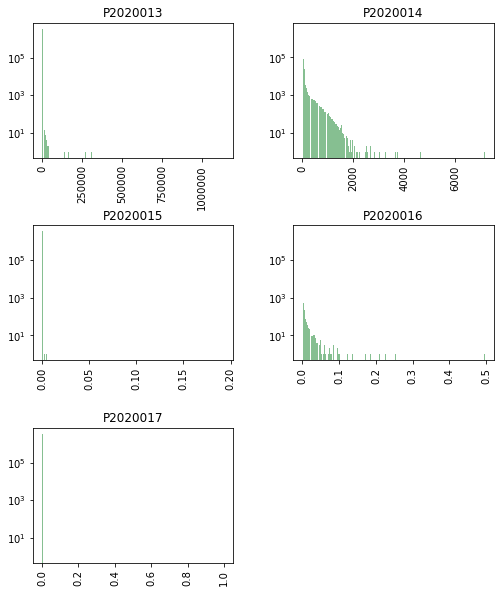

In [5]:
df = pd.read_csv('/Users/amandeep/Github/kgtk/graph_analysis_covid_sorted_2.tsv', sep='\t', dtype=object)
df['node2'] = df['node2'].map(lambda x: float(x))
hist = df.hist(column='node2', by='property',figsize=(8,10), color='#86bf91', zorder=2, rwidth=0.9, bins=250, log=True)